# Final Project

Name & ID
* Hesham Zaky - 210051646
* Rafaa Al-Alwani - 210038844

In [1]:
!pip install -qU wandb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
elegy 0.8.6 requires wandb<0.13.0,>=0.12.10, but you have wandb 0.16.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!git clone https://github.com/rishigami/Swin-Transformer-TF
    
import sys
sys.path.append('/kaggle/working/Swin-Transformer-TF')

Cloning into 'Swin-Transformer-TF'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 44 (delta 15), reused 7 (delta 7), pack-reused 26
Receiving objects: 100% (44/44), 15.90 KiB | 15.90 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
import math, re, os, random
import numpy as np
import pandas as pd
import wandb
from wandb.integration.keras import WandbCallback
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, \
                            recall_score, confusion_matrix

import tensorflow as tf
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import layers as L
from tensorflow.keras import callbacks
from swintransformer import SwinTransformer

print("TF version " + tf.__version__)

D1202 14:39:30.899595897      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1202 14:39:30.899625140      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1202 14:39:30.899629579      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1202 14:39:30.899632889      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1202 14:39:30.899635900      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1202 14:39:30.899642989      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1202 14:39:30.899645930      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1202 14:39:30.

TF version 2.12.0


/usr/local/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret('wandb_key')
    wandb.login(key=api_key)
    anonymous = None
except:
    wandb.login(anonymous='must')
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your \
           W&B access token. Use the Label name as WANDB. \nGet your W&B access \
           token from here: https://wandb.ai/authorize')

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


To use your W&B account,
Go to Add-ons -> Secrets and provide your            W&B access token. Use the Label name as WANDB. 
Get your W&B access            token from here: https://wandb.ai/authorize


## TPU detection

In [5]:
AUTO = tf.data.AUTOTUNE

def get_strategy():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    except ValueError:
        strategy = tf.distribute.get_strategy()
    return strategy


# Detect hardware, return appropriate distribution strategy
strategy = get_strategy()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


## Configuration

In [6]:
seed = 42

image_size = [224, 224]
epochs = 30
batch_size = 32 * strategy.num_replicas_in_sync

swin_type = 'large'

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
set_seed(seed)

## Data access and classes

In [7]:
ds_path = '/kaggle/input/tpu-getting-started'
ds_path_ext = '/kaggle/input/tf-flower-photo-tfrec'

# available image sizes
data_path_select = { 
    192: ds_path + '/tfrecords-jpeg-192x192',
    224: ds_path + '/tfrecords-jpeg-224x224',
    331: ds_path + '/tfrecords-jpeg-331x331',
    512: ds_path + '/tfrecords-jpeg-512x512'
}
data_path = data_path_select[image_size[0]]

# External data
data_path_select_ext = {
    192: '/tfrecords-jpeg-192x192',
    224: '/tfrecords-jpeg-224x224',
    331: '/tfrecords-jpeg-331x331',
    512: '/tfrecords-jpeg-512x512'
}
data_path_ext = data_path_select_ext[image_size[0]]

imagenet_files = tf.io.gfile.glob(ds_path_ext + '/imagenet' + data_path_ext + '/*.tfrec')
inaturelist_files = tf.io.gfile.glob(ds_path_ext + '/inaturalist' + data_path_ext + '/*.tfrec')
openimage_files = tf.io.gfile.glob(ds_path_ext + '/openimage' + data_path_ext + '/*.tfrec')
oxford_files = tf.io.gfile.glob(ds_path_ext + '/oxford_102' + data_path_ext + '/*.tfrec')
tensorflow_files = tf.io.gfile.glob(ds_path_ext + '/tf_flowers' + data_path_ext + '/*.tfrec')

additional_training_filenames = imagenet_files + inaturelist_files + openimage_files + oxford_files + tensorflow_files  

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                          # 100 - 102

training_filenames = tf.io.gfile.glob(data_path + '/train/*.tfrec')
validation_filenames = tf.io.gfile.glob(data_path + '/val/*.tfrec')
test_filenames = tf.io.gfile.glob(data_path + '/test/*.tfrec')

training_filenames = training_filenames + additional_training_filenames

## Visualization functions

In [8]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Random erasing (blockout) augmentation

In [9]:
def random_erasing(img, sl=0.1, sh=0.2, rl=0.4, p=0.3):
    h = tf.shape(img)[0]
    w = tf.shape(img)[1]
    c = tf.shape(img)[2]
    origin_area = tf.cast(h*w, tf.float32)

    e_size_l = tf.cast(tf.round(tf.sqrt(origin_area * sl * rl)), tf.int32)
    e_size_h = tf.cast(tf.round(tf.sqrt(origin_area * sh / rl)), tf.int32)

    e_height_h = tf.minimum(e_size_h, h)
    e_width_h = tf.minimum(e_size_h, w)

    erase_height = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_height_h, dtype=tf.int32)
    erase_width = tf.random.uniform(shape=[], minval=e_size_l, maxval=e_width_h, dtype=tf.int32)

    erase_area = tf.zeros(shape=[erase_height, erase_width, c])
    erase_area = tf.cast(erase_area, tf.uint8)

    pad_h = h - erase_height
    pad_top = tf.random.uniform(shape=[], minval=0, maxval=pad_h, dtype=tf.int32)
    pad_bottom = pad_h - pad_top

    pad_w = w - erase_width
    pad_left = tf.random.uniform(shape=[], minval=0, maxval=pad_w, dtype=tf.int32)
    pad_right = pad_w - pad_left

    erase_mask = tf.pad([erase_area], [[0,0],[pad_top, pad_bottom], [pad_left, pad_right], [0,0]], constant_values=1)
    erase_mask = tf.squeeze(erase_mask, axis=0)
    erased_img = tf.multiply(tf.cast(img,tf.float32), tf.cast(erase_mask, tf.float32))

    return tf.cond(tf.random.uniform([], 0, 1) > p, lambda: tf.cast(img, img.dtype), lambda:  tf.cast(erased_img, img.dtype))

## Dataset functions

In [10]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*image_size, 3])
    return image

def onehot(image,label):
    return image,tf.one_hot(label, len(CLASSES))

def read_labeled_tfrecord(example):
    labeled_tfrec_format = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, labeled_tfrec_format)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def read_unlabeled_tfrecord(example):
    unlabeled_tfrec_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "id": tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, unlabeled_tfrec_format)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = random_erasing(image)
    return image, label

def data_hflip(image, idnum):
    image = tf.image.flip_left_right(image)
    image = tf.image.flip_up_down(image)
    return image, idnum

def get_training_dataset(do_onehot=False):
    dataset = load_dataset(training_filenames, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if do_onehot:
        dataset = dataset.map(onehot, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False, do_onehot=False):
    dataset = load_dataset(validation_filenames, labeled=True, ordered=ordered)
    if do_onehot:
        dataset = dataset.map(onehot, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False, augmented=False):
    dataset = load_dataset(test_filenames, labeled=False, ordered=ordered)
    if augmented:
        dataset = dataset.map(data_hflip, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

num_training_images = count_data_items(training_filenames)
num_validation_images = count_data_items(validation_filenames)
num_test_images = count_data_items(test_filenames)
steps_per_epoch = num_training_images // batch_size
print(f'dataset: {num_training_images} training images, {num_validation_images} validation images, {num_test_images} unlabeled test images')

dataset: 68094 training images, 3712 validation images, 7382 unlabeled test images


## Dataset visualizations

In [11]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U'))

Training data shapes:
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
Training data label examples: [73 30 41 ...  4 45  4]
Validation data shapes:
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
Validation data label examples: [51 47 22 ... 68 47 73]
Test data shapes:
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
(256, 224, 224, 3) (256,)
Test data IDs: ['50a645c94' 'eda20ddee' '2d0fa50dd' ... 'ed8f1770c' 'b94381f7b' '264d83a6c']


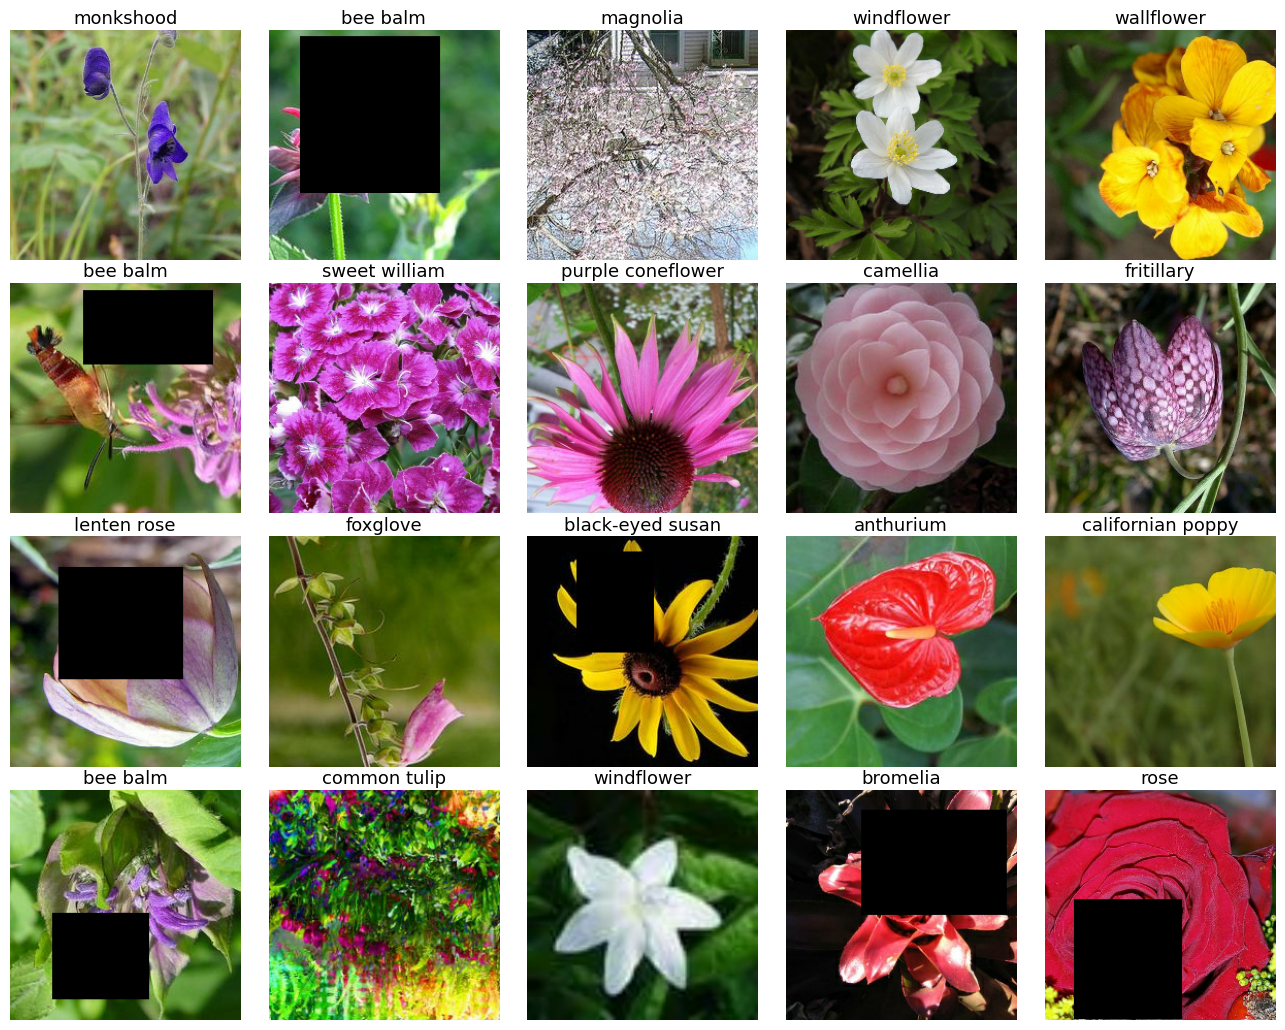

In [12]:
# Peek at training data
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

display_batch_of_images(next(train_batch))

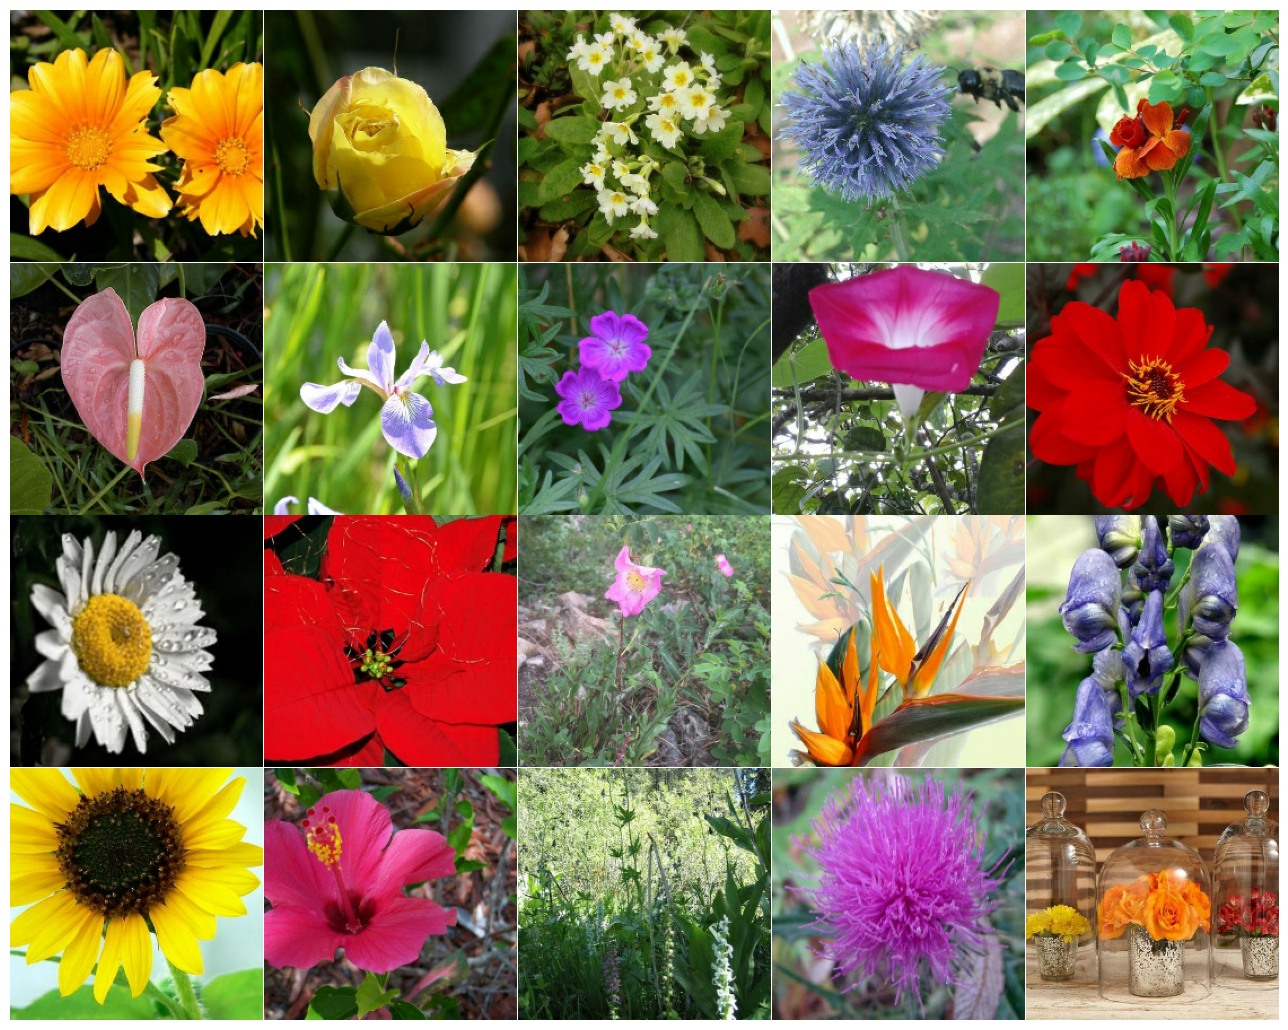

In [13]:
# peer at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

display_batch_of_images(next(test_batch))

## Define and train the model

### Custom LR scheduler

In [14]:
def get_lr_callback(plot_schedule=False):
    lr_start = 0.00001
    lr_max = 0.00005 * strategy.num_replicas_in_sync
    lr_min = 0.00001
    lr_rampup_epochs = 5
    lr_sustain_epochs = 0
    lr_exp_decay = .8

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    if plot_schedule:
        rng = [i for i in range(25 if epochs < 25 else epochs)]
        y = [lrfn(x) for x in rng]
        plt.plot(rng, y)

    return callbacks.LearningRateScheduler(lrfn, verbose=0)

In [15]:
def load_and_fit_model(print_summary=False):
    with strategy.scope():
        model = tf.keras.Sequential([
            SwinTransformer(f'swin_{swin_type}_{image_size[0]}', 
                                         include_top=False, 
                                         pretrained=True),
            L.Dense(len(CLASSES), activation='softmax')
        ])
        
        model.compile(
            optimizer='adam',
            loss = 'categorical_crossentropy',
            metrics=[F1Score(len(CLASSES), average='macro')]
        )

    if print_summary:
        model.summary()
        
    os.makedirs('checkpoints', exist_ok=True)
    
    lr_callback = get_lr_callback()
    chk_callback = callbacks.ModelCheckpoint(f'checkpoints/swin_{swin_type}_best',
                     save_weights_only=True, monitor='val_f1_score',
                     mode='max', save_best_only=True, verbose=1)
    
    wandb.init(project='flower-classification-tpu-public', 
               name='swin_large_v25',
               job_type='train', 
               reinit=True)
    log_callback = WandbCallback(
        monitor='val_f1_score',
        mode='max',
        save_model=False
    )

    _ = model.fit(get_training_dataset(do_onehot=True), 
                  steps_per_epoch=steps_per_epoch, 
                  epochs=epochs, 
                  validation_data=get_validation_dataset(do_onehot=True),
                  callbacks=[lr_callback, chk_callback, log_callback],
                  verbose=2)
    model.load_weights(f'checkpoints/swin_{swin_type}_best')
    wandb.finish()
    return model

### Train model

In [16]:
model = load_and_fit_model()

722592300/722592300 [==============================] - 3s 0us/step


wandb: Currently logged in as: anony-moose-907743398939255218. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.16.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231202_144034-gnwooe03
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run swin_large_v25
wandb: ⭐️ View project at https://wandb.ai/anony-moose-907743398939255218/flower-classification-tpu-public?apiKey=7be3458abebe5452b697d855e61f4860f3274ead
wandb: 🚀 View run at https://wandb.ai/anony-moose-907743398939255218/flower-classification-tpu-public/runs/gnwooe03?apiKey=7be3458abebe5452b697d855e61f4860f3274ead
wandb: WARNING Do NOT share these links with anyone. They can be used to claim your runs.


Epoch 1/30


2023-12-02 14:41:33.862776: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-12-02 14:41:35.611859: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-12-02 14:47:13.862147: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-12-02 14:47:14.252735: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



Epoch 1: val_f1_score improved from -inf to 0.85973, saving model to checkpoints/swin_large_best
265/265 - 440s - loss: 1.6384 - f1_score: 0.4631 - val_loss: 0.4441 - val_f1_score: 0.8597 - lr: 1.0000e-05 - 440s/epoch - 2s/step
Epoch 2/30

Epoch 2: val_f1_score improved from 0.85973 to 0.93874, saving model to checkpoints/swin_large_best
265/265 - 244s - loss: 0.2921 - f1_score: 0.8943 - val_loss: 0.2332 - val_f1_score: 0.9387 - lr: 8.8000e-05 - 244s/epoch - 921ms/step
Epoch 3/30

Epoch 3: val_f1_score did not improve from 0.93874
265/265 - 215s - loss: 0.2066 - f1_score: 0.9251 - val_loss: 0.2571 - val_f1_score: 0.9332 - lr: 1.6600e-04 - 215s/epoch - 811ms/step
Epoch 4/30

Epoch 4: val_f1_score did not improve from 0.93874
265/265 - 214s - loss: 0.1866 - f1_score: 0.9319 - val_loss: 0.3672 - val_f1_score: 0.9191 - lr: 2.4400e-04 - 214s/epoch - 809ms/step
Epoch 5/30

Epoch 5: val_f1_score did not improve from 0.93874
265/265 - 215s - loss: 0.1833 - f1_score: 0.9350 - val_loss: 0.4216 

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:        epoch ▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
wandb:     f1_score ▁▇▇▇▇▇▇███████████████████████
wandb:         loss █▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:           lr ▁▂▄▅▇█▇▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: val_f1_score ▁▆▆▅▄▄▅▆▆▆▆▇▇▇▇▇▇█████████████
wandb:     val_loss ▇▂▂▅▇█▆▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: 
wandb: Run summary:
wandb:        best_epoch 29
wandb: best_val_f1_score 0.96928
wandb:             epoch 29
wandb:          f1_score 0.99816
wandb:              loss 0.00609
wandb:                lr 1e-05
wandb:      val_f1_score 0.96928
wandb:          val_loss 0.20868
wandb: 
wandb: 🚀 View run swin_large_v25 at: https://wandb.ai/anony-moose-907743398939255218/flower-classification-tpu-public/runs/gnwooe03?apiKey=7be3458abebe5452b697d855e61f4860f3274ead
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wan

## Plot confusion matrix and predict on test dataset

In [17]:
def predict(dataset, model):
    print('Calculating predictions...')
    images_ds = dataset.map(lambda image, idnum: image)
    preds = model.predict(images_ds,verbose=0)
    return preds

Calculating predictions...


2023-12-02 16:37:20.209157: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-12-02 16:37:20.602189: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


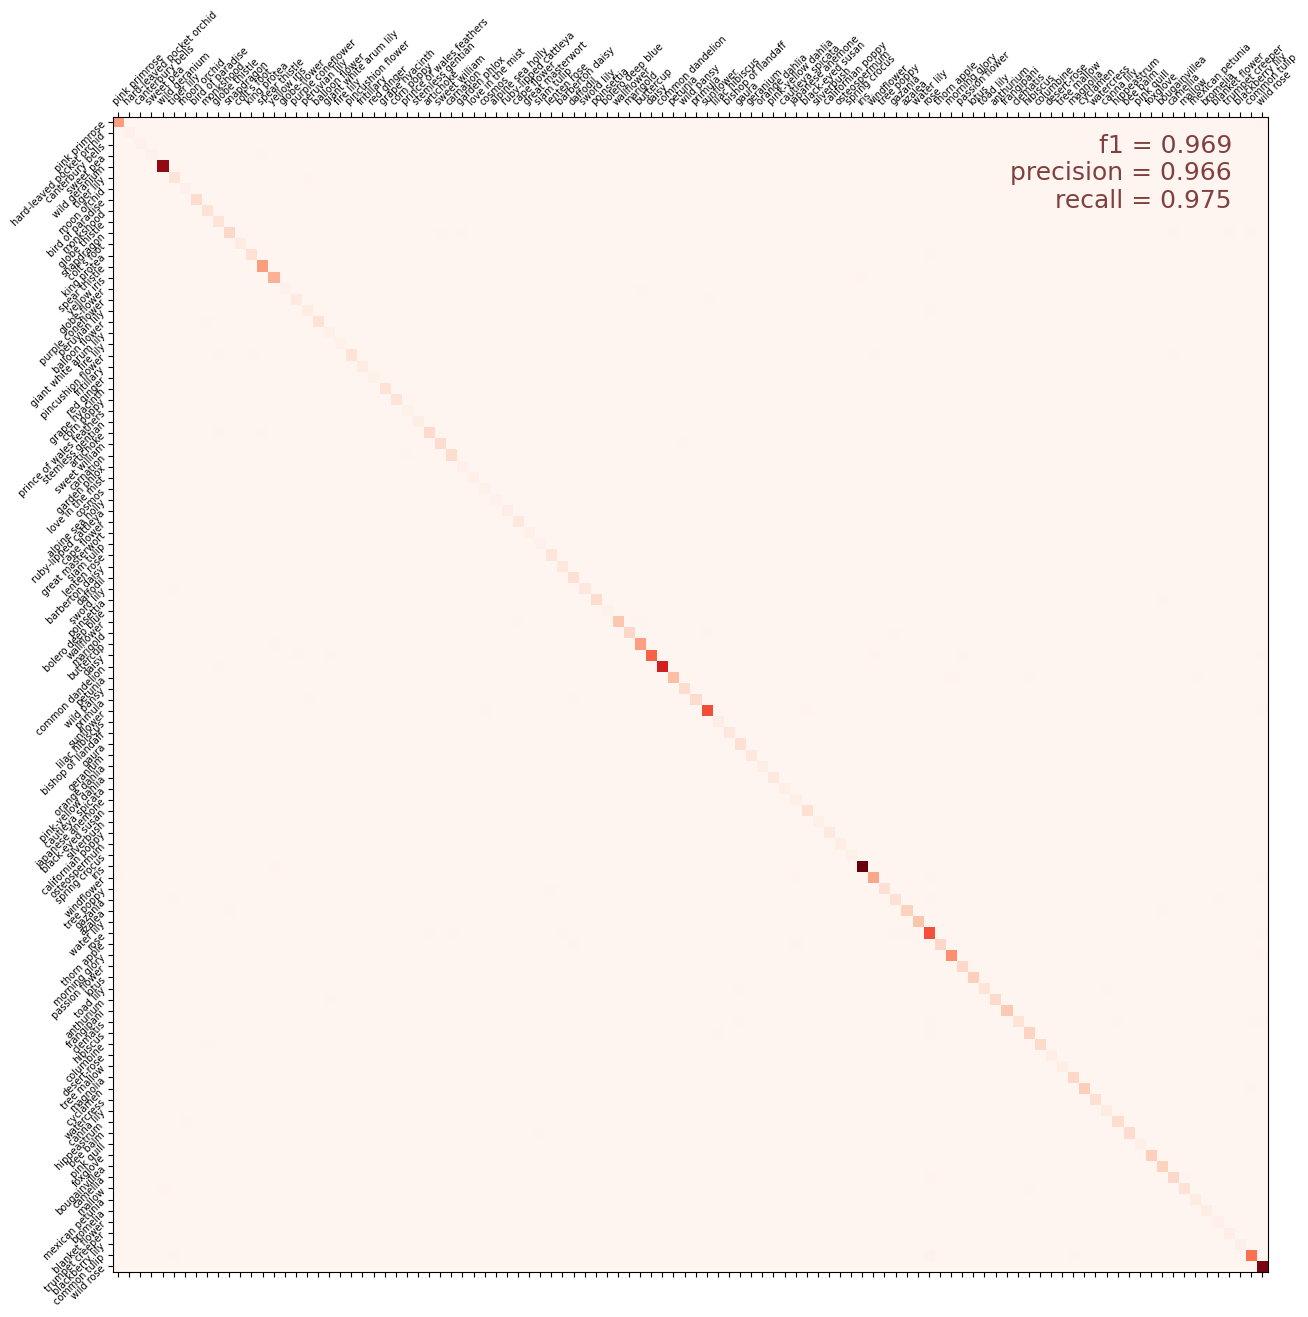

In [18]:
valid_ds = get_validation_dataset(ordered=True)
cm_predictions = predict(valid_ds, model)
cm_predictions = np.argmax(cm_predictions, axis=1)

labels_ds = valid_ds.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(num_validation_images))).numpy() # get everything as one batch

cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
display_confusion_matrix(cmat, score, precision, recall)

In [19]:
test_ds_1 = get_test_dataset(ordered=True, augmented=False)
preds_1 = predict(test_ds_1, model)

test_ds_2 = get_test_dataset(ordered=True, augmented=True)
preds_2 = predict(test_ds_2, model)

preds = (preds_1 + preds_2) / 2
preds = np.argmax(preds, axis=1)

print('Generating submission file...')
test_ids_ds = test_ds_1.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(num_test_images))).numpy().astype('U') # all in one batch
                 
sub_df = pd.DataFrame({'id': test_ids, 'label': preds})
sub_df.to_csv('submission.csv', index=False)

Calculating predictions...
Calculating predictions...
Generating submission file...
